## Gravitational Wave

## Load Data

In [15]:
## Initialize envornmental variables

# Standard python numerical analysis imports:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# the ipython magic below must be commented out in the .py file, since it doesn't work.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

# LIGO-specific readligo.py 
import readligo as rl


def LIGO(nameH1, nameL1, nameNR, timeShift):
    #----------------------------------------------------------------
    # Load LIGO data from a single file
    #----------------------------------------------------------------
    # First from H1
    fn_H1 = nameH1
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    # and then from L1
    fn_L1 = nameL1
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
    
    #event occurance for GW150914
    #tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015
    tevent, shift = timeShift[0], timeShift[1]

    # sampling rate:
    fs = 4096
    # both H1 and L1 will have the same time vector, so:
    time = time_H1
    # the time sample interval (uniformly sampled!)
    dt = time[1] - time[0]

    # read in the NR template
    fn_NR = nameNR # 'data/GW150914_4_NR_waveform.txt'
    NRtime, NR_H1 = np.genfromtxt(fn_NR).transpose()

    #----------------------------------------------------------------
    # Run all calculations
    #----------------------------------------------------------------

    # number of sample for the fast fourier transform:
    NFFT = 1*fs
    fmin = 10
    fmax = 2000
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
    Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

    # We will use interpolations of the ASDs (Pxx's) computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1)
    psd_L1 = interp1d(freqs, Pxx_L1)

    # function to whiten data
    def whiten(strain, interp_psd, dt):
        Nt = len(strain)
        freqs = np.fft.rfftfreq(Nt, dt)

        # whitening: transform to freq domain, divide by asd, then transform back, 
        # taking care to get normalization right.
        hf = np.fft.rfft(strain)
        white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
        white_ht = np.fft.irfft(white_hf, n=Nt)
        return white_ht

    # now whiten the data from H1 and L1, and also the NR template:
    strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
    strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
    NR_H1_whiten = whiten(NR_H1,psd_H1,dt)

    # number of sample for the fast fourier transform:
    NFFT = 1*fs
    fmin = 10
    fmax = 2000
    Pxx_H1_whiten, freqs = mlab.psd(strain_H1_whiten, Fs = fs, NFFT = NFFT)
    Pxx_L1_whiten, freqs = mlab.psd(strain_L1_whiten, Fs = fs, NFFT = NFFT)

    # We will use interpolations of the ASDs computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1_whiten)
    psd_L1 = interp1d(freqs, Pxx_L1_whiten)

    # We need to suppress the high frequencies with some bandpassing:
    bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
    strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten)
    strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten)
    NR_H1_whitenbp = filtfilt(bb, ab, NR_H1_whiten)
    
    # plot the data after whitening:
    # first, shift L1 by 7 ms, and invert. See the GW150914 detection paper for why!
    strain_L1_shift = -np.roll(strain_L1_whitenbp,int(0.007*fs))

    #----------------------------------------------------------------
    # Pandas Dataframes
    #----------------------------------------------------------------

    # Time domain for strain data
    S2_dict = {'time': time_H1, 'strain_L1': strain_L1, 'strain_H1': strain_H1, 
               'strain_L1_whiten': strain_L1_whiten, 'strain_H1_whiten': strain_H1_whiten, 
               'strain_H1_whitenbp': strain_H1_whitenbp, 'strain_L1_whitenbp': strain_L1_shift }
    S2 = pd.DataFrame(data=S2_dict)
    S2['time'] = pd.to_datetime(S2['time'],unit='s', origin=pd.Timestamp('1980-01-06'))
    
    # Comparison waveform
    NR_dict = {'NRtime': NRtime, 'NR_Waveform': NR_H1_whitenbp}
    NR = pd.DataFrame(data=NR_dict)
    NR['time'] = pd.to_datetime(tevent+NR['NRtime']+shift,unit='s', origin=pd.Timestamp('1980-01-06'))

    # Frequency domain
    F2_dict = {'freq': freqs, 'Pxx_H1': np.sqrt(Pxx_H1), 'Pxx_L1': np.sqrt(Pxx_L1), 
               'Pxx_H1_whiten': np.sqrt(Pxx_H1_whiten), 'Pxx_L1_whiten': np.sqrt(Pxx_L1_whiten)}
    F2 = pd.DataFrame(data=F2_dict)
    
    return(S2, F2, NR)

## Load GW Events

In [16]:
# Call the function.
# Returns whitened data in time domain (S2), frequency domain (F2), and matched waveform
# Event 2 copies time and waveform of event 1. Simply for calling functions
# Collected data from: https://losc.ligo.org/events/

fn_NR = 'data/GW150914_4_NR_waveform.txt'

#**************************************************
# GW1 - GW150914 (4096 seconds)
#**************************************************
fn_H1V1 = 'data/H-H1_LOSC_4_V1-1126257414-4096.hdf5'
fn_L1V1 = 'data/L-L1_LOSC_4_V1-1126257414-4096.hdf5'
teventV1 = 1126259462.422
shiftV1 = 0.002
S1_EV1 = {'H1': fn_H1V1, 'L1': fn_L1V1, 'tevent': teventV1, 'shift': shiftV1}
#S2V1, F2V1, NRV1 = LIGO(fn_H1V1, fn_L1V1, fn_NR, [teventV1,shiftV1])

#**************************************************
# GW2 - GW151226 (4096 seconds)
#**************************************************
fn_H1V2 = 'data/H-H1_LOSC_4_V2-1135136228-4096.hdf5'
fn_L1V2 = 'data/L-L1_LOSC_4_V2-1135136228-4096.hdf5'
teventV2 = 1135136350.65  # December 26 2015, 03:38:53.65 UTC
shiftV2 = 0.002
S1_EV2 = {'H1': fn_H1V2, 'L1': fn_L1V2, 'tevent': teventV2, 'shift': shiftV2}
#S2V2, F2V2, NRV2 = LIGO(fn_H1V2, fn_L1V2, fn_NR, [teventV2,shiftV2])

#**************************************************
# GW3 - GW170104 (4096 seconds)
#**************************************************
fn_H1V3 = 'data/H-H1_LOSC_4_V1-1167557888-4096.hdf5'
fn_L1V3 = 'data/L-L1_LOSC_4_V1-1167557888-4096.hdf5'
teventV3 = 1167559936.6  # January 04 2017, 10:11:58.6 UTC
shiftV3 = 0.002
S1_EV3 = {'H1': fn_H1V3, 'L1': fn_L1V3, 'tevent': teventV3, 'shift': shiftV3}
#S2V3, F2V3, NRV3 = LIGO(fn_H1V3, fn_L1V3, fn_NR, [teventV3,shiftV3])

#**************************************************
#GW4 - GW170608 (512 seconds)
#**************************************************
fn_H1V4 = 'data/H-H1_LOSC_CLN_4_V1-1180922238-512.hdf5'
fn_L1V4 = 'data/L-L1_LOSC_CLN_4_V1-1180922238-512.hdf5'
teventV4 = 1180922494.49  # June 08 2017, 02:01:16.49 UTC
shiftV4 = 0.002
S1_EV4 = {'H1': fn_H1V4, 'L1': fn_L1V4, 'tevent': teventV4, 'shift': shiftV4}
#S2V4, F2V4, NRV4 = LIGO(fn_H1V4, fn_L1V4, fn_NR, [teventV4,shiftV4])

#**************************************************
# GW5 - GW170814 (3584 seconds)
#**************************************************
fn_H1V5 = 'data/H-H1_LOSC_CLN_4_V1-1186740069-3584.hdf5'
fn_L1V5 = 'data/L-L1_LOSC_CLN_4_V1-1186740069-3584.hdf5'
teventV5 = 1186741861.53  # August 14 2017, 10:30:43.53 UTC
shiftV5 = 0.002
S1_EV5 = {'H1': fn_H1V5, 'L1': fn_L1V5, 'tevent': teventV5, 'shift': shiftV5}
#S2V5, F2V5, NRV5 = LIGO(fn_H1V5, fn_L1V5, fn_NR, [teventV5,shiftV5])

#**************************************************
# GW6 - GW170817 (2048 seconds)
#**************************************************
fn_H1V6 = 'data/H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5'
fn_L1V6 = 'data/L-L1_LOSC_CLN_4_V1-1187007040-2048.hdf5'
teventV6 = 1187008882.43  # August 17 2017, 12:41:04.43 UTC
shiftV6 = 0.002
S1_EV6 = {'H1': fn_H1V6, 'L1': fn_L1V6, 'tevent': teventV6, 'shift': shiftV6}
#S2V6, F2V6, NRV6 = LIGO(fn_H1V6, fn_L1V6, fn_NR, [teventV6,shiftV6])

S2 = {'GW1': S1_EV1, 'GW2': S1_EV2, 'GW3': S1_EV3, 'GW4': S1_EV4, 'GW5': S1_EV5, 'GW6': S1_EV6}

## Observe cleaned form from first GW

In [17]:
def plotEvent(S2, NR, tevent, columns):
    # plot +- .5 seconds around the event:
    #tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
    #tevent = pd.to_datetime(tevent, unit='s', origin=pd.Timestamp('1980-01-06'))
    deltat = .05                     # seconds around the event
    deltat = pd.Timedelta(seconds=deltat)
    # index into the strain time series for this time interval:
    S2_windowed = S2[(S2['time'] > tevent-2*deltat) & (S2['time'] < tevent+deltat)]
    NR_windowed = NR[(NR['time'] > tevent-2*deltat) & (NR['time'] < tevent+deltat)]


    fig, axes = plt.subplots(figsize=(20,12), nrows=1, ncols=1)

    axes.plot(S2_windowed['time'], S2_windowed[columns[0]],'r',label=columns[0])
    axes.plot(S2_windowed['time'], S2_windowed[columns[1]],'g',label=columns[2])
    axes.plot(NR_windowed['time'],NR_windowed[columns[2]],'k',label=columns[2])
    axes.set_title('time series of GW whitened and bandpassed ~0.05 seconds around event')

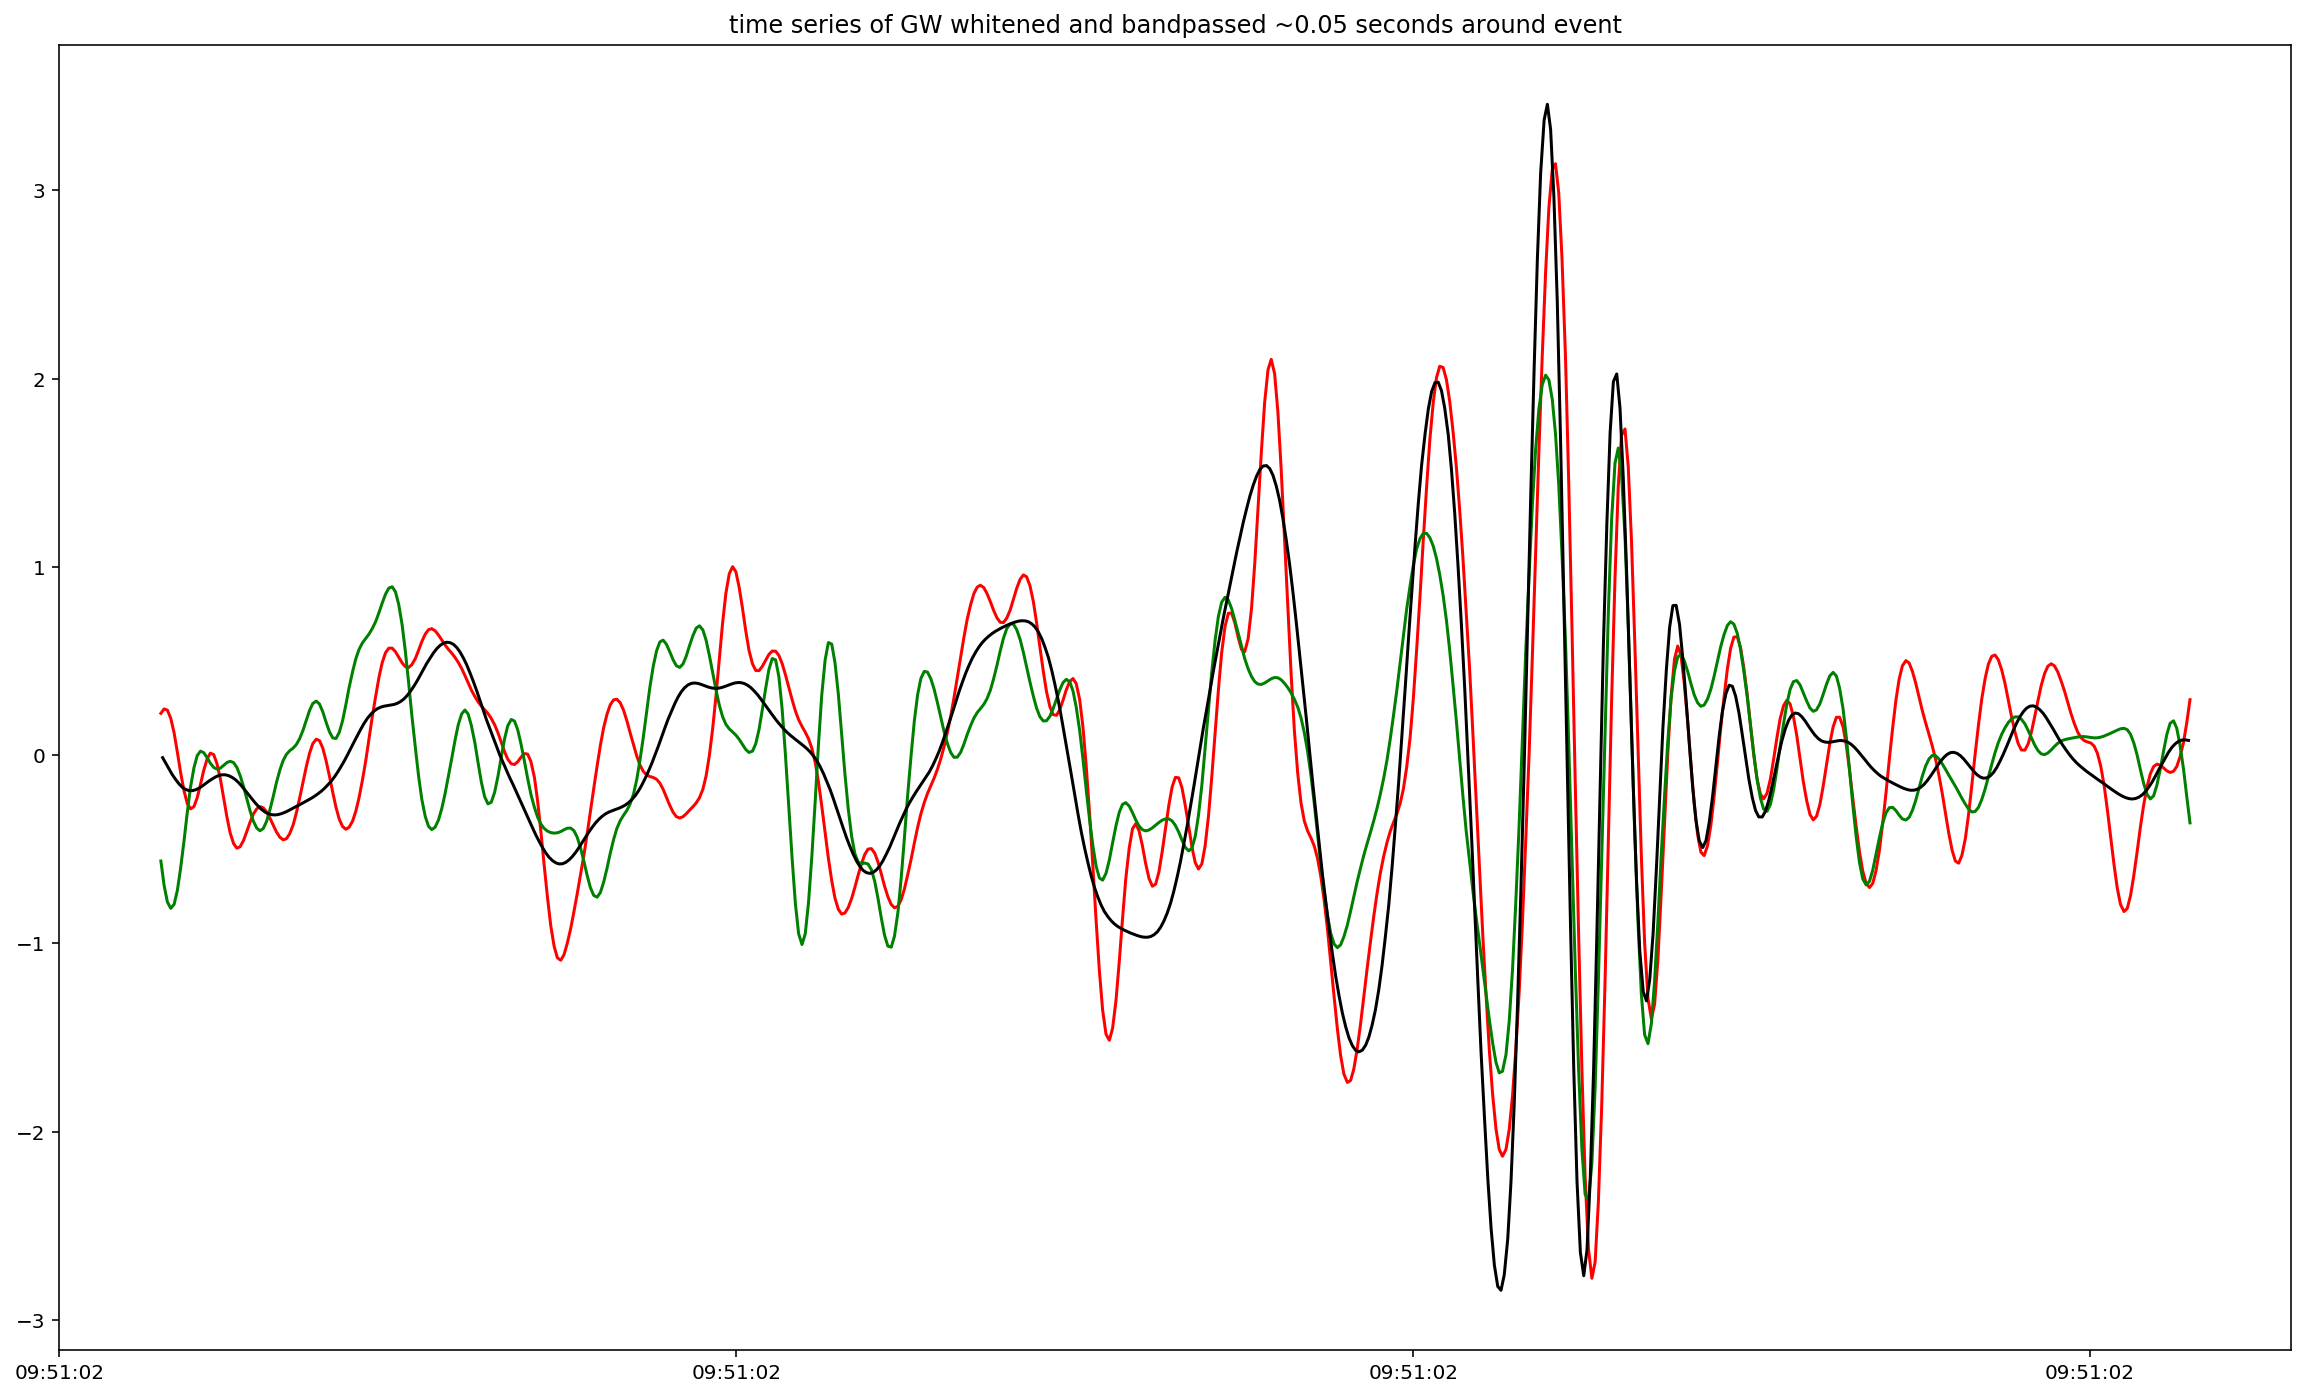

In [18]:
S2V1, F2V1, NRV1 = LIGO(S2['GW1']['H1'], S2['GW1']['L1'], fn_NR, [S2['GW1']['tevent'],S2['GW1']['shift']])
teventV1 = pd.to_datetime(S2['GW1']['tevent'], unit='s', origin=pd.Timestamp('1980-01-06'))
cols = ['strain_H1_whitenbp', 'strain_L1_whitenbp', 'NR_Waveform']
plotEvent(S2V1, NRV1, teventV1, cols)

## Form windows based off first GW

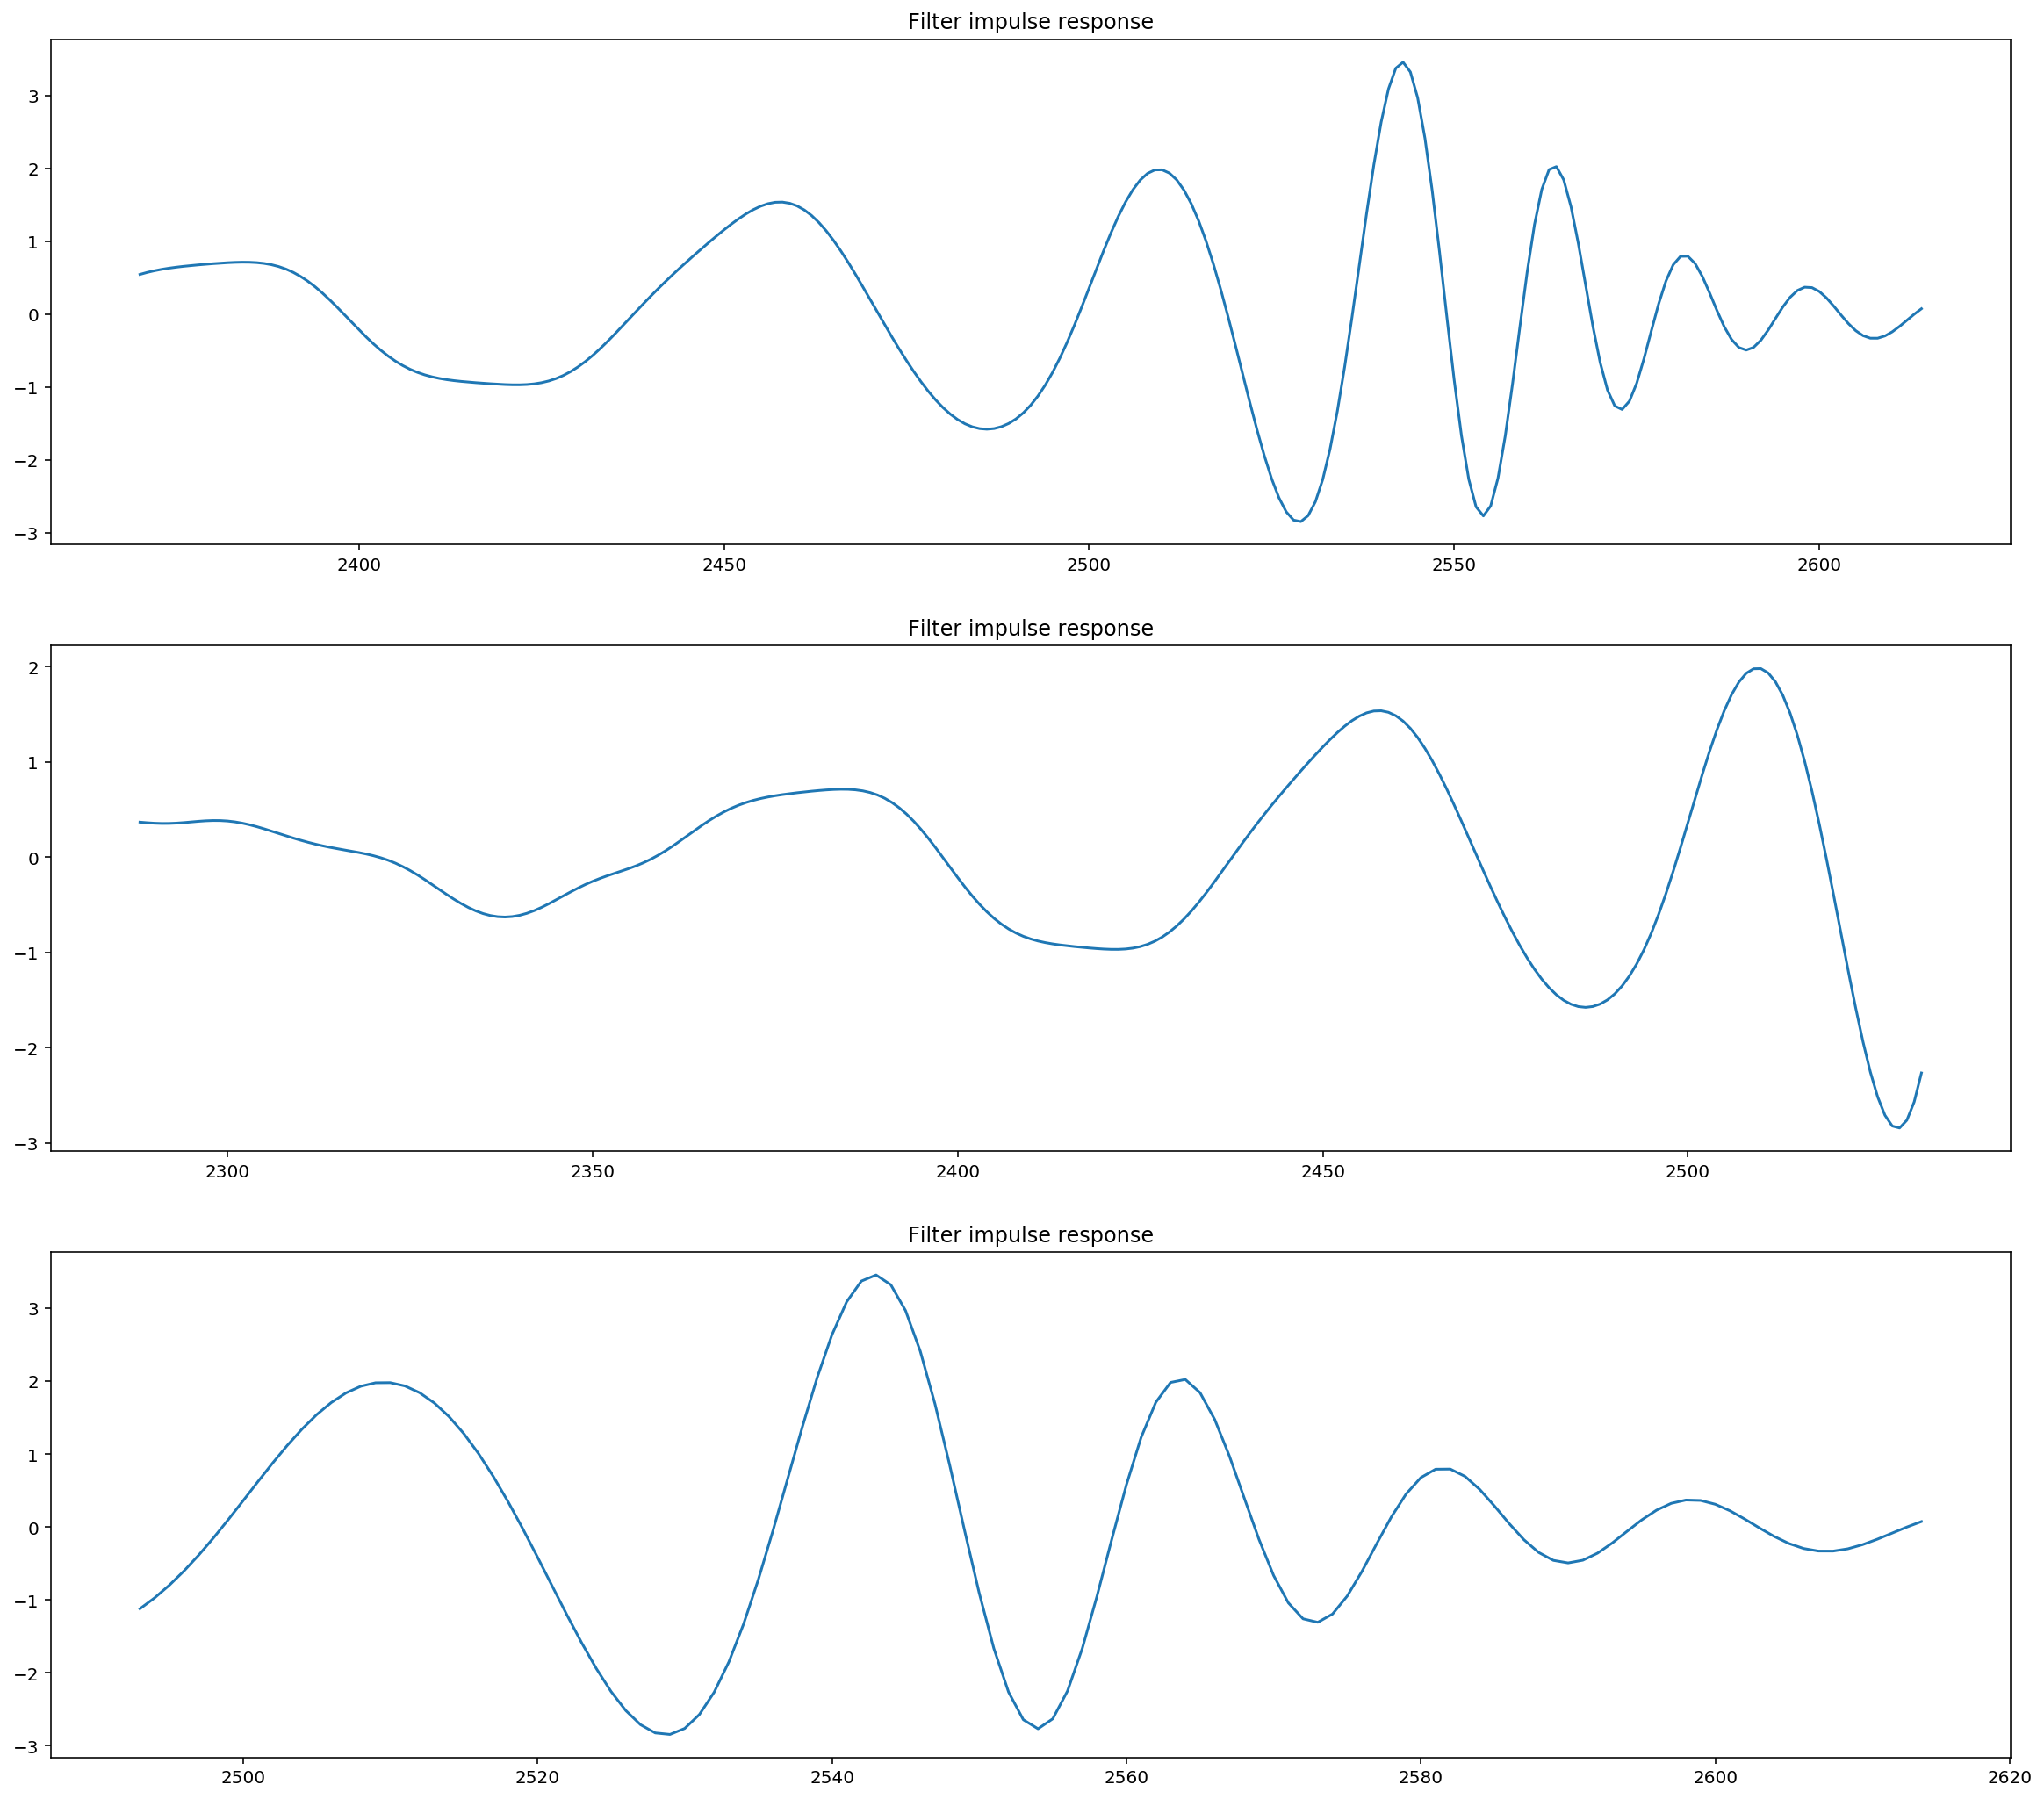

In [19]:
tevent = pd.to_datetime(S2['GW1']['tevent'], unit='s', origin=pd.Timestamp('1980-01-06'))
deltat = .02                     # seconds around the event
deltat = pd.Timedelta(seconds=deltat)

NR_windowed1 = NRV1[(NRV1['time'] > tevent-2*deltat) & (NRV1['time'] < tevent+deltat)]
NR_windowed2 = NRV1[(NRV1['time'] > tevent-3*deltat) & (NRV1['time'] < tevent)]
NR_windowed3 = NRV1[(NRV1['time'] > tevent-0.5*deltat) & (NRV1['time'] < tevent+deltat)]

win1 = NR_windowed1['NR_Waveform']
win2 = NR_windowed2['NR_Waveform']
win3 = NR_windowed3['NR_Waveform']
windows = [win1, win2, win3]

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20,18), nrows=3, ncols=1)
ax1.plot(win1)
ax1.set_title('Filter impulse response')
ax2.plot(win2)
ax2.set_title('Filter impulse response')
ax3.plot(win3)
ax3.set_title('Filter impulse response')

In [23]:
def window_transform(win, i=0, fs=4096):
    #fs = 4096
    idx = np.arange(0,len(win), 1)
    cosx = np.cos(idx*i/fs*np.pi)
    
    fourier_win = np.fft.rfft(win) * np.fft.rfft(cosx)
    inverse_win = np.fft.ifft(fourier_win)
    
    return(inverse_win)

def signal_convolve(sig, window):
    # trim due to conversion back to time domain, funny stuff with ends
    trim = 4096 * 2
    trimmed_sig = sig[trim:-trim]

    convolved = signal.correlate(trimmed_sig, window, mode='same') / sum(window)
    return(convolved)

def first_layer(sig, windows, n_freqs, fs):
    '''
    first layer, calculate convolution of signal with three windows
    '''
    
    cosmic_convolution = []
    for win_i in windows:
        for i in n_freqs:
            transformed_i = window_transform(win_i, i, fs)
            convolved_signal = signal_convolve(sig, transformed_i)
            cosmic_convolution.append(convolved_signal)
    return(cosmic_convolution)


def output_layer(cosmic_convolution):
    '''
    output layer, average
    '''   
    cosmic_convolution_mean = np.average(cosmic_convolution, axis=0)
    return(cosmic_convolution_mean)

"""
def output_layer(cosmic_convolution):
    '''
    output layer, average
    '''   
    cosmic_convolution_agg = []
    for i in range(0,len(cosmic_convolution[0])):
        cosmic_convolution_i = []
        for j in range(0,len(cosmic_convolution)):
            cosmic_convolution_i.append(cosmic_convolution[j][i])
        cosmic_convolution_agg.append(np.mean(cosmic_convolution_i))
    return(cosmic_convolution_agg)
"""

def plot_NN(sig_output, i):
    plt.rcParams['agg.path.chunksize'] = 20000

    fig, ax = plt.subplots(figsize=(20,12), nrows=1, ncols=1, sharex=False)

    ax.plot(sig_output)
    ax.set_title(str(i) + ' NN output')
    plt.show()

Loading, cleaning, and whitening GW1


C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  return out.astype(volume.dtype)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Loading, cleaning, and whitening GW2
Loading, cleaning, and whitening GW3
Loading, cleaning, and whitening GW4
Loading, cleaning, and whitening GW5
Loading, cleaning, and whitening GW6


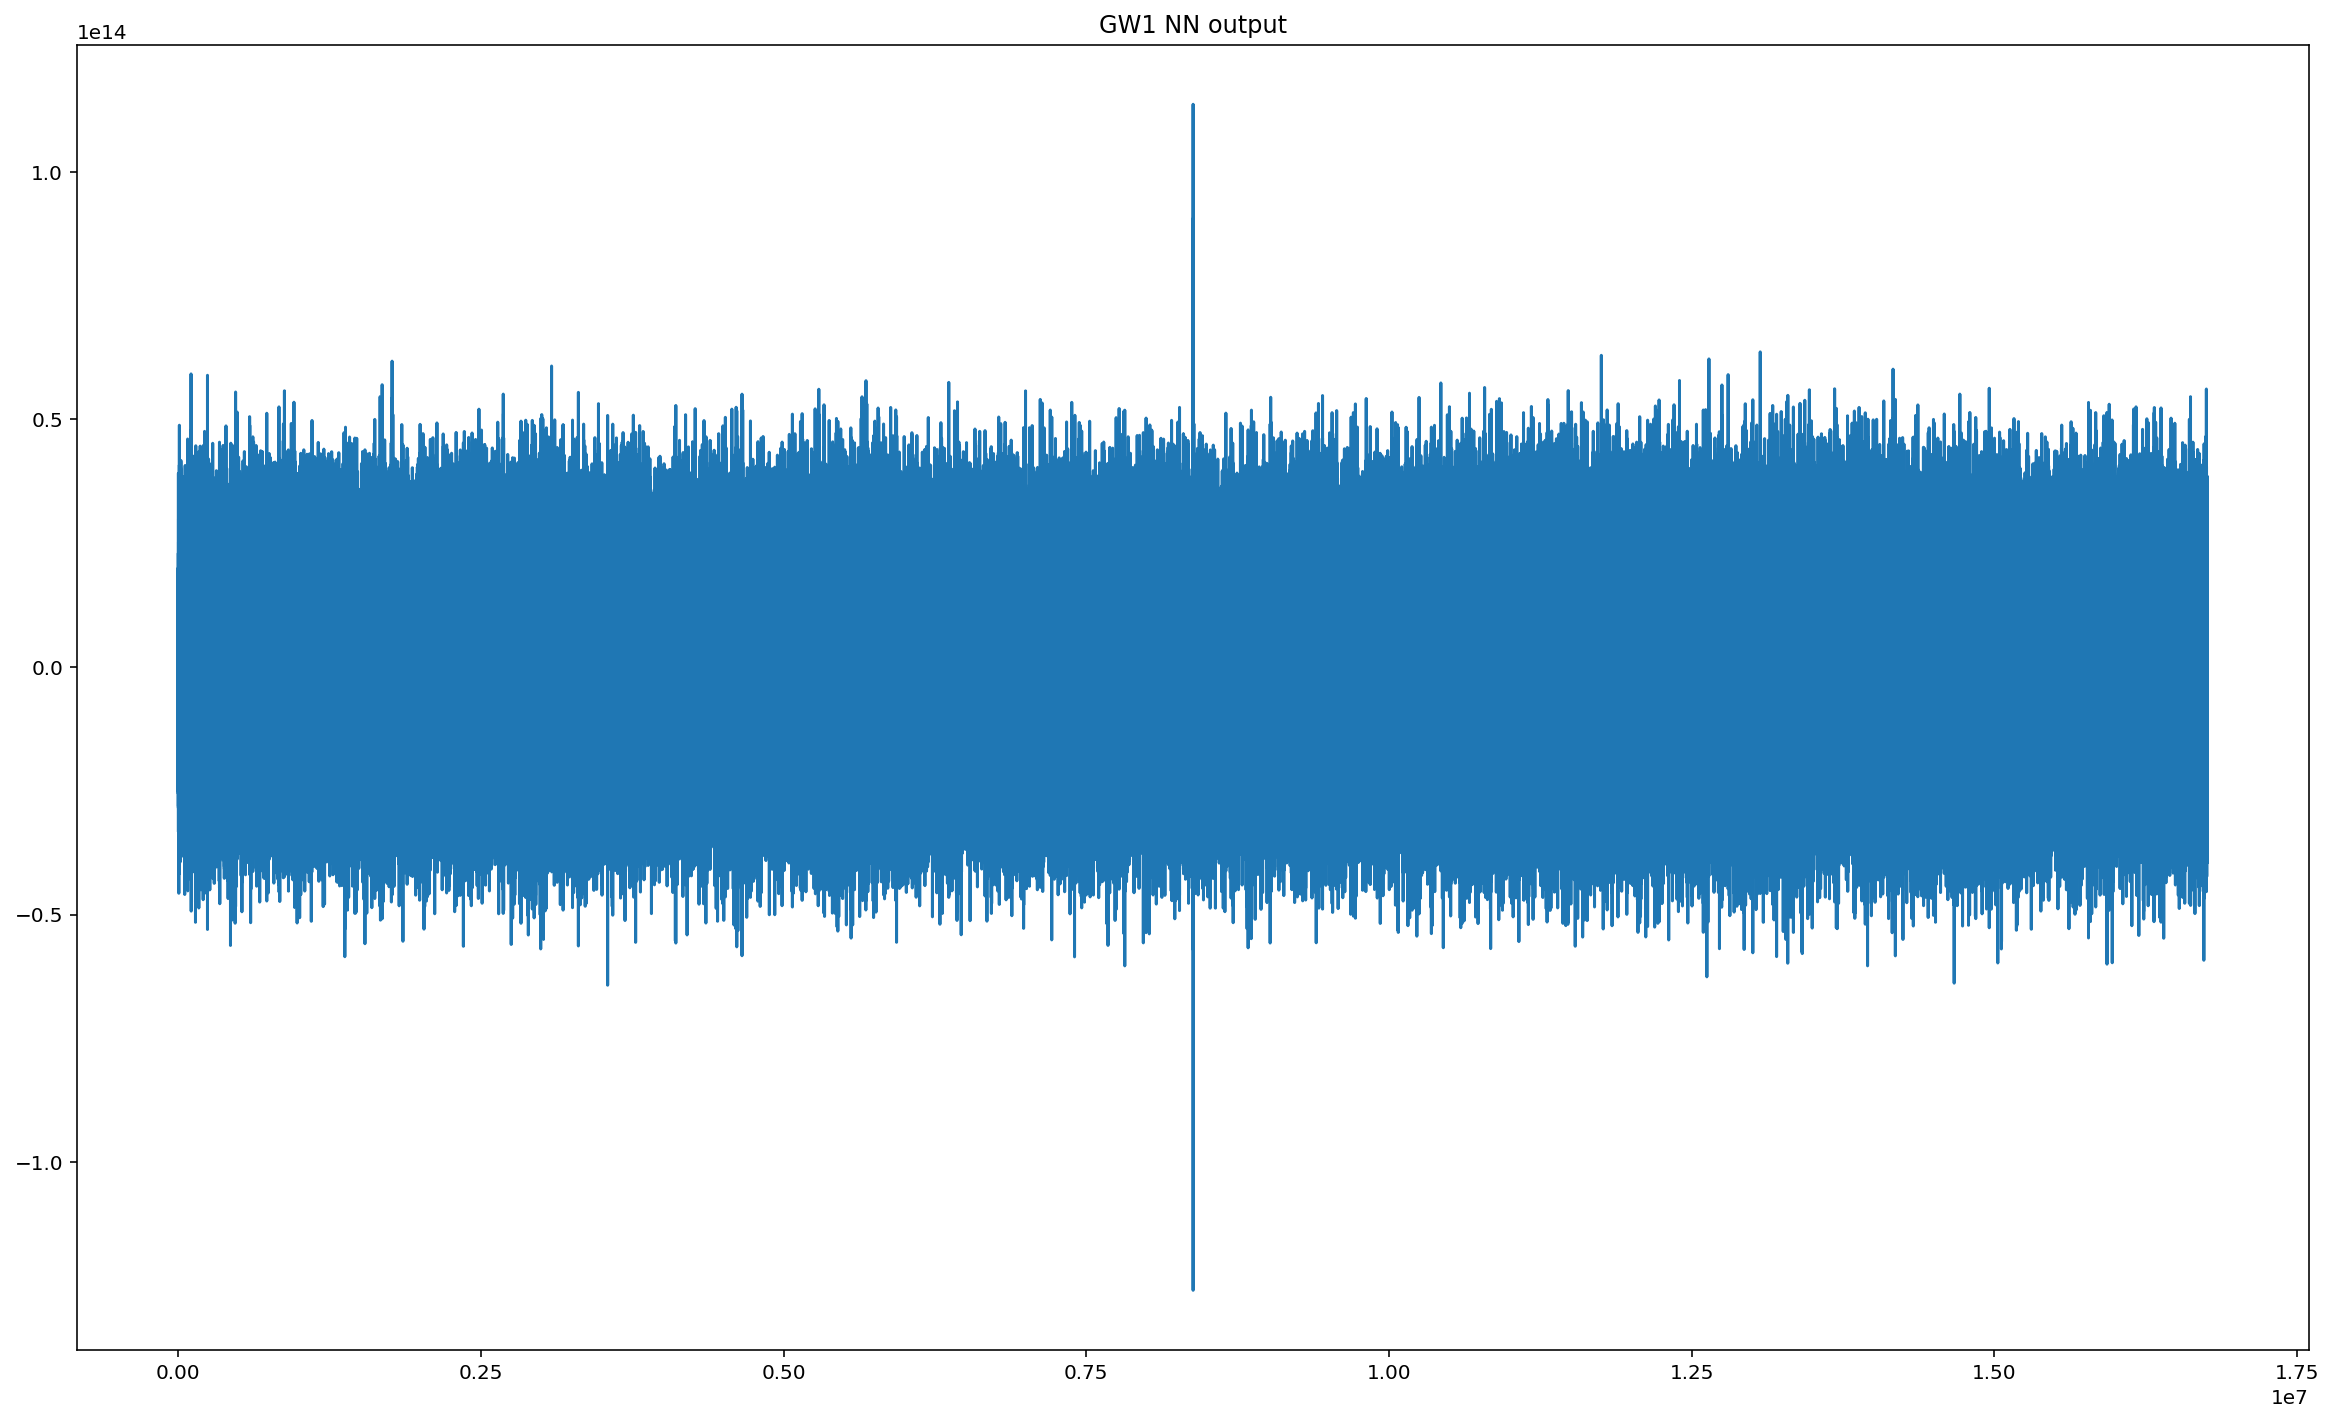

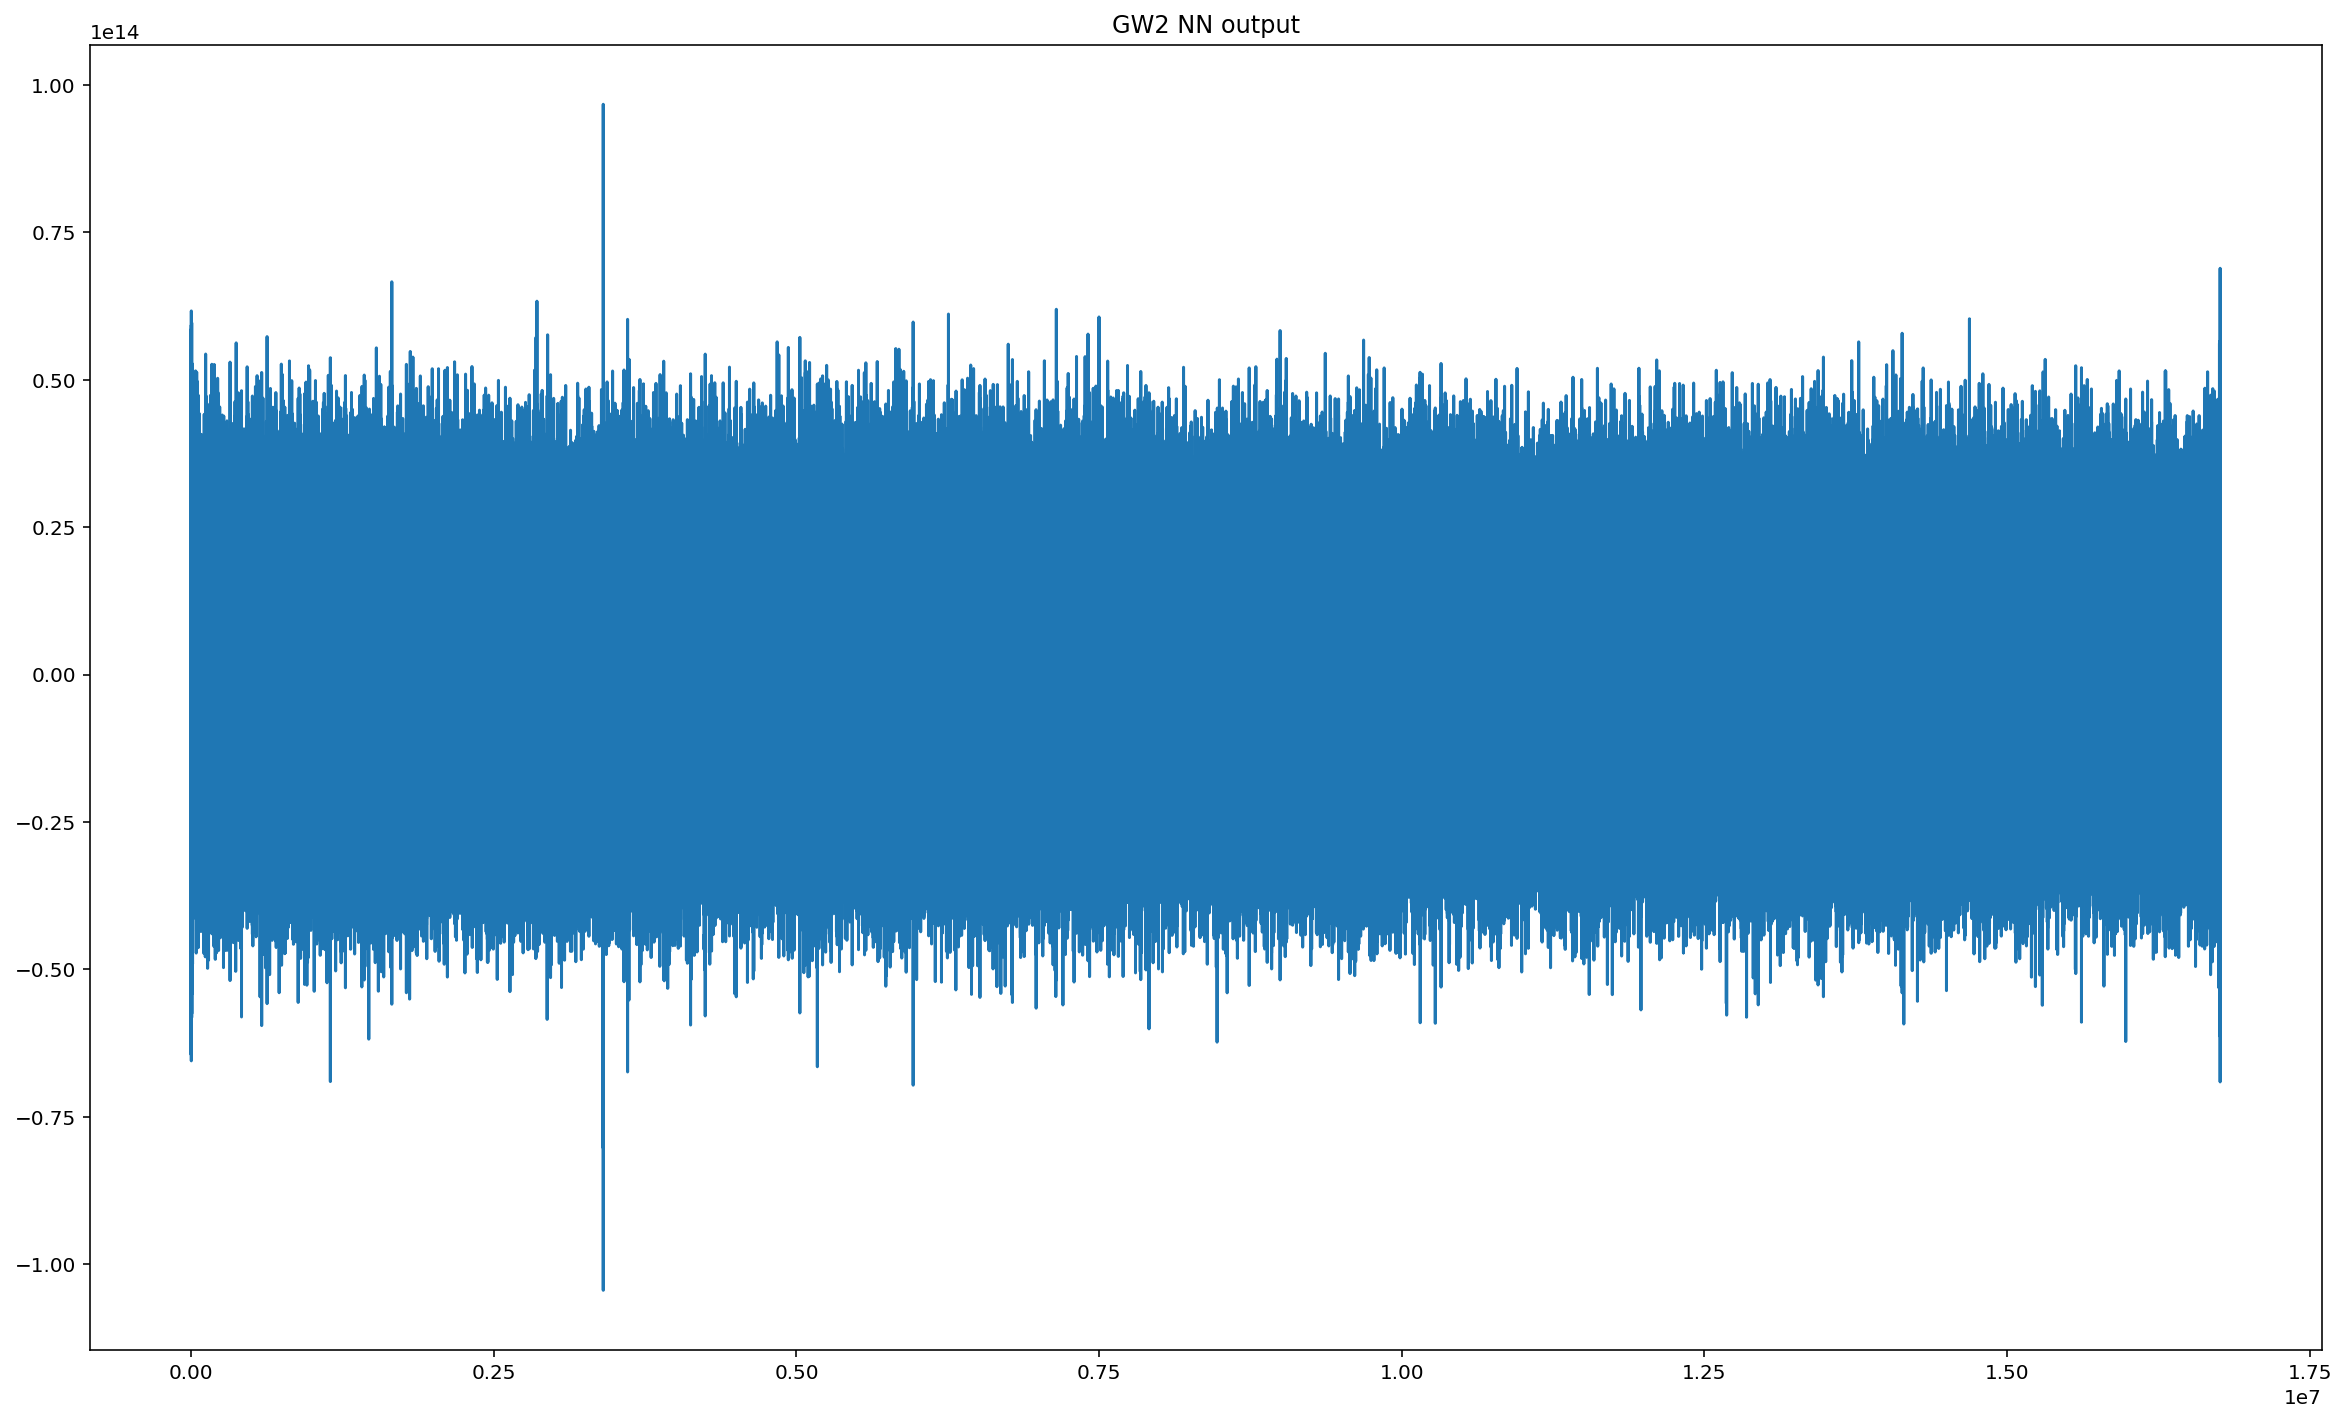

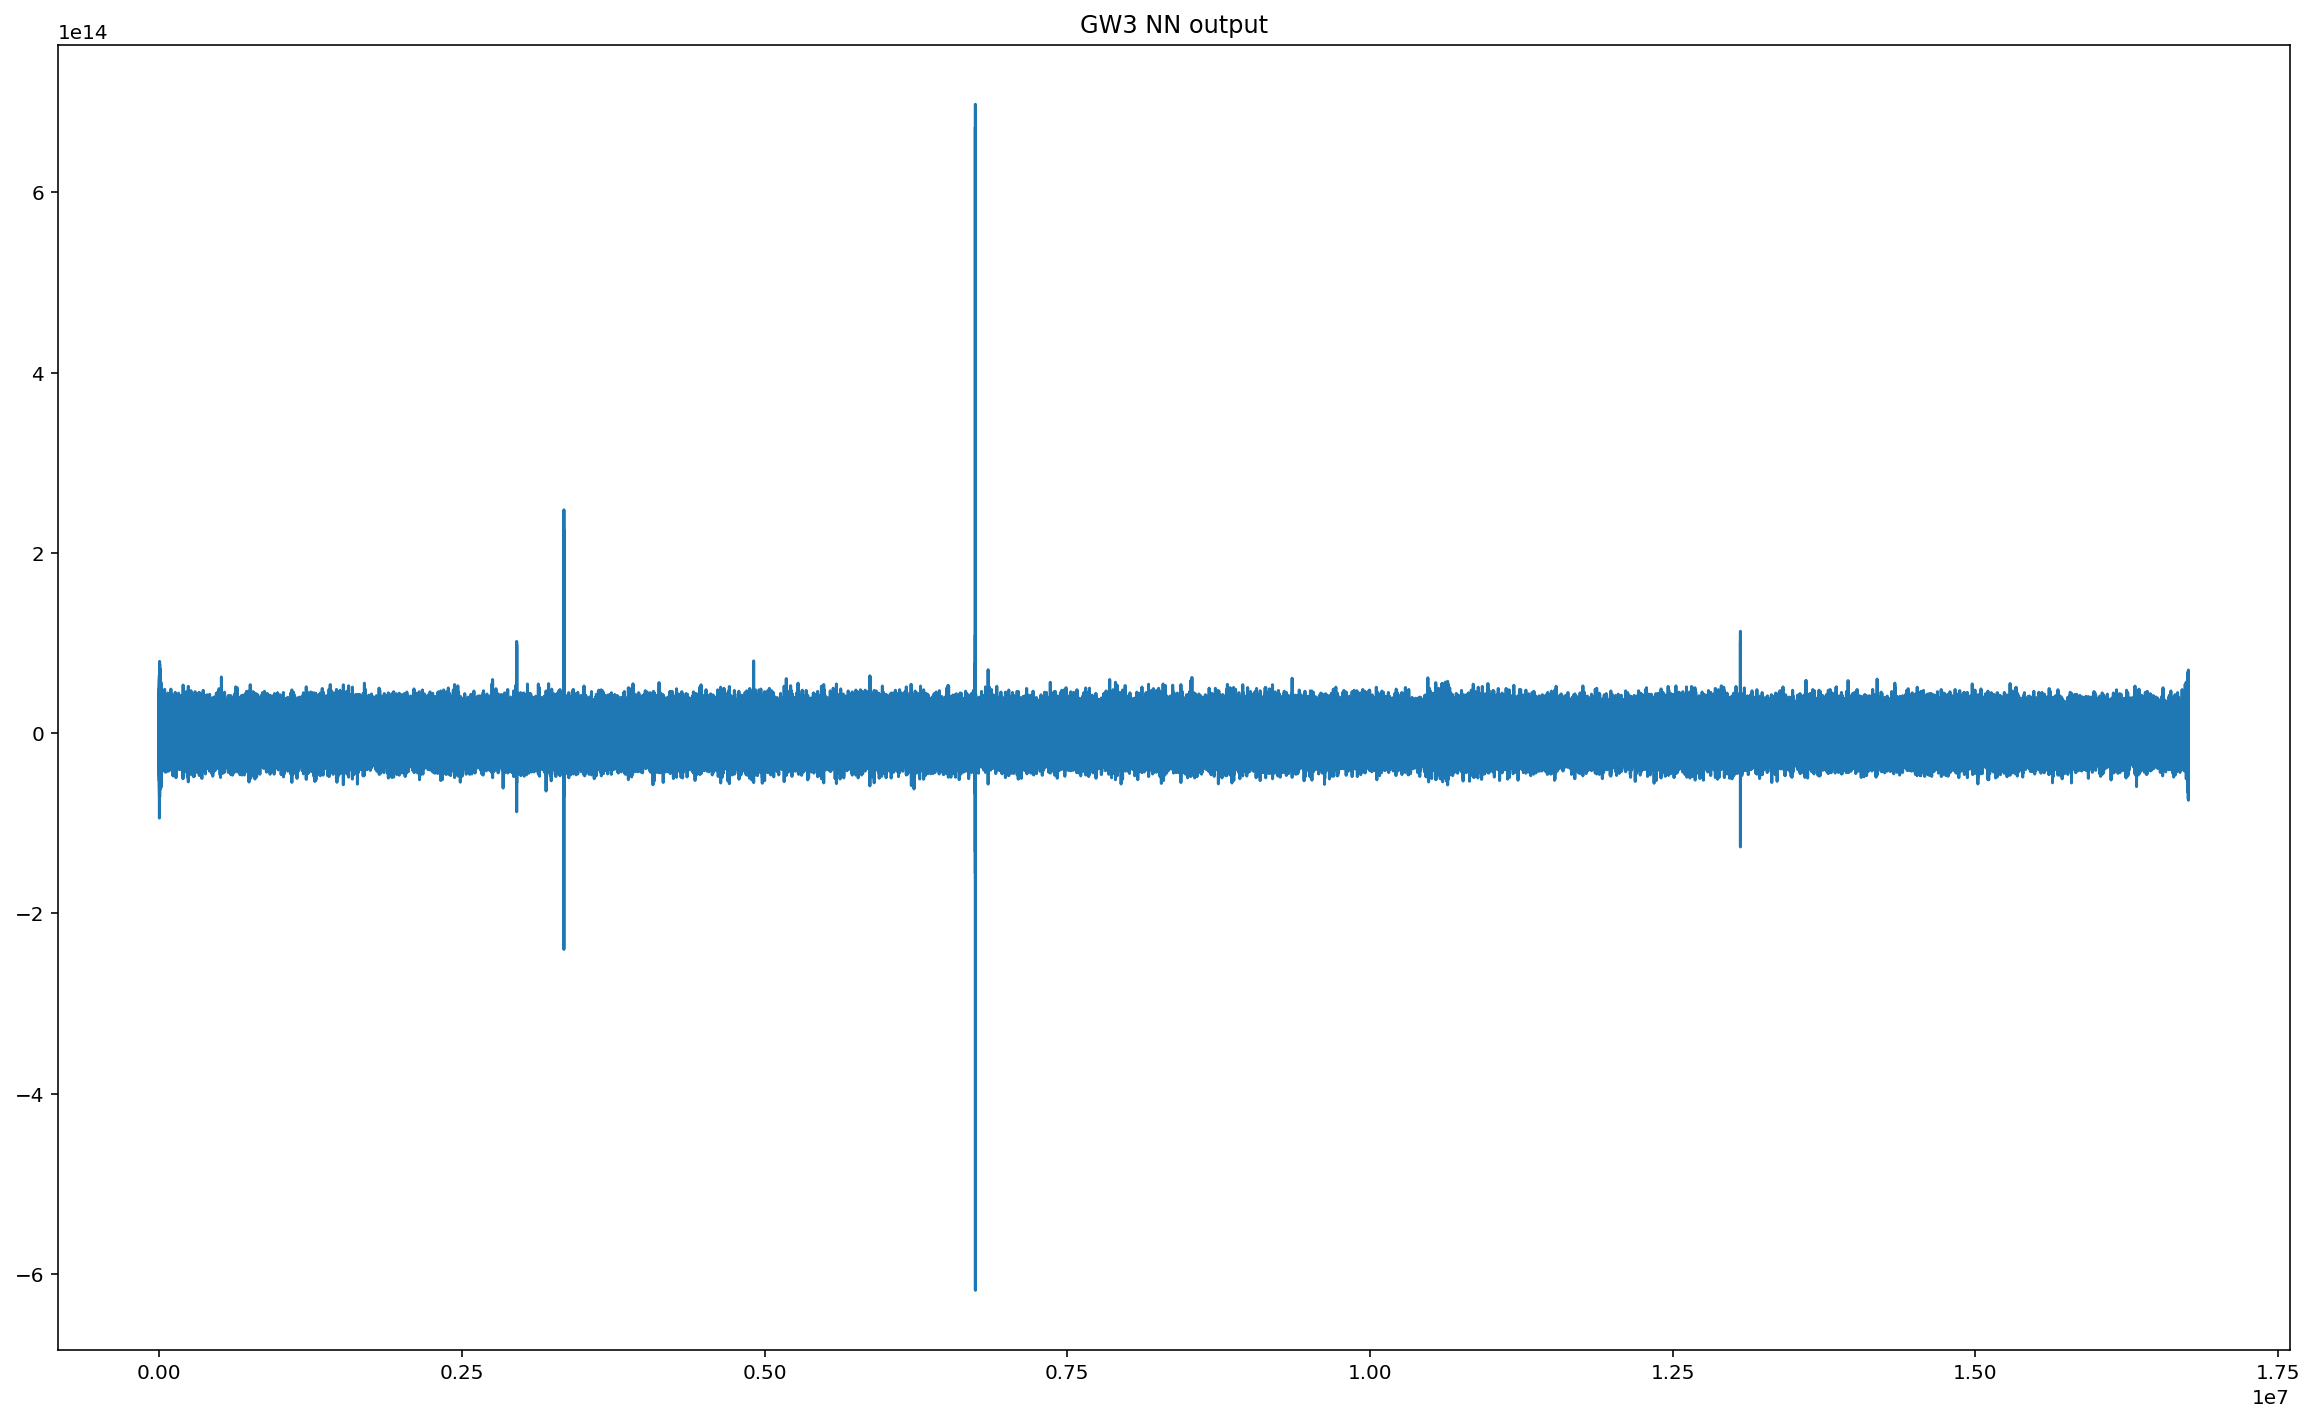

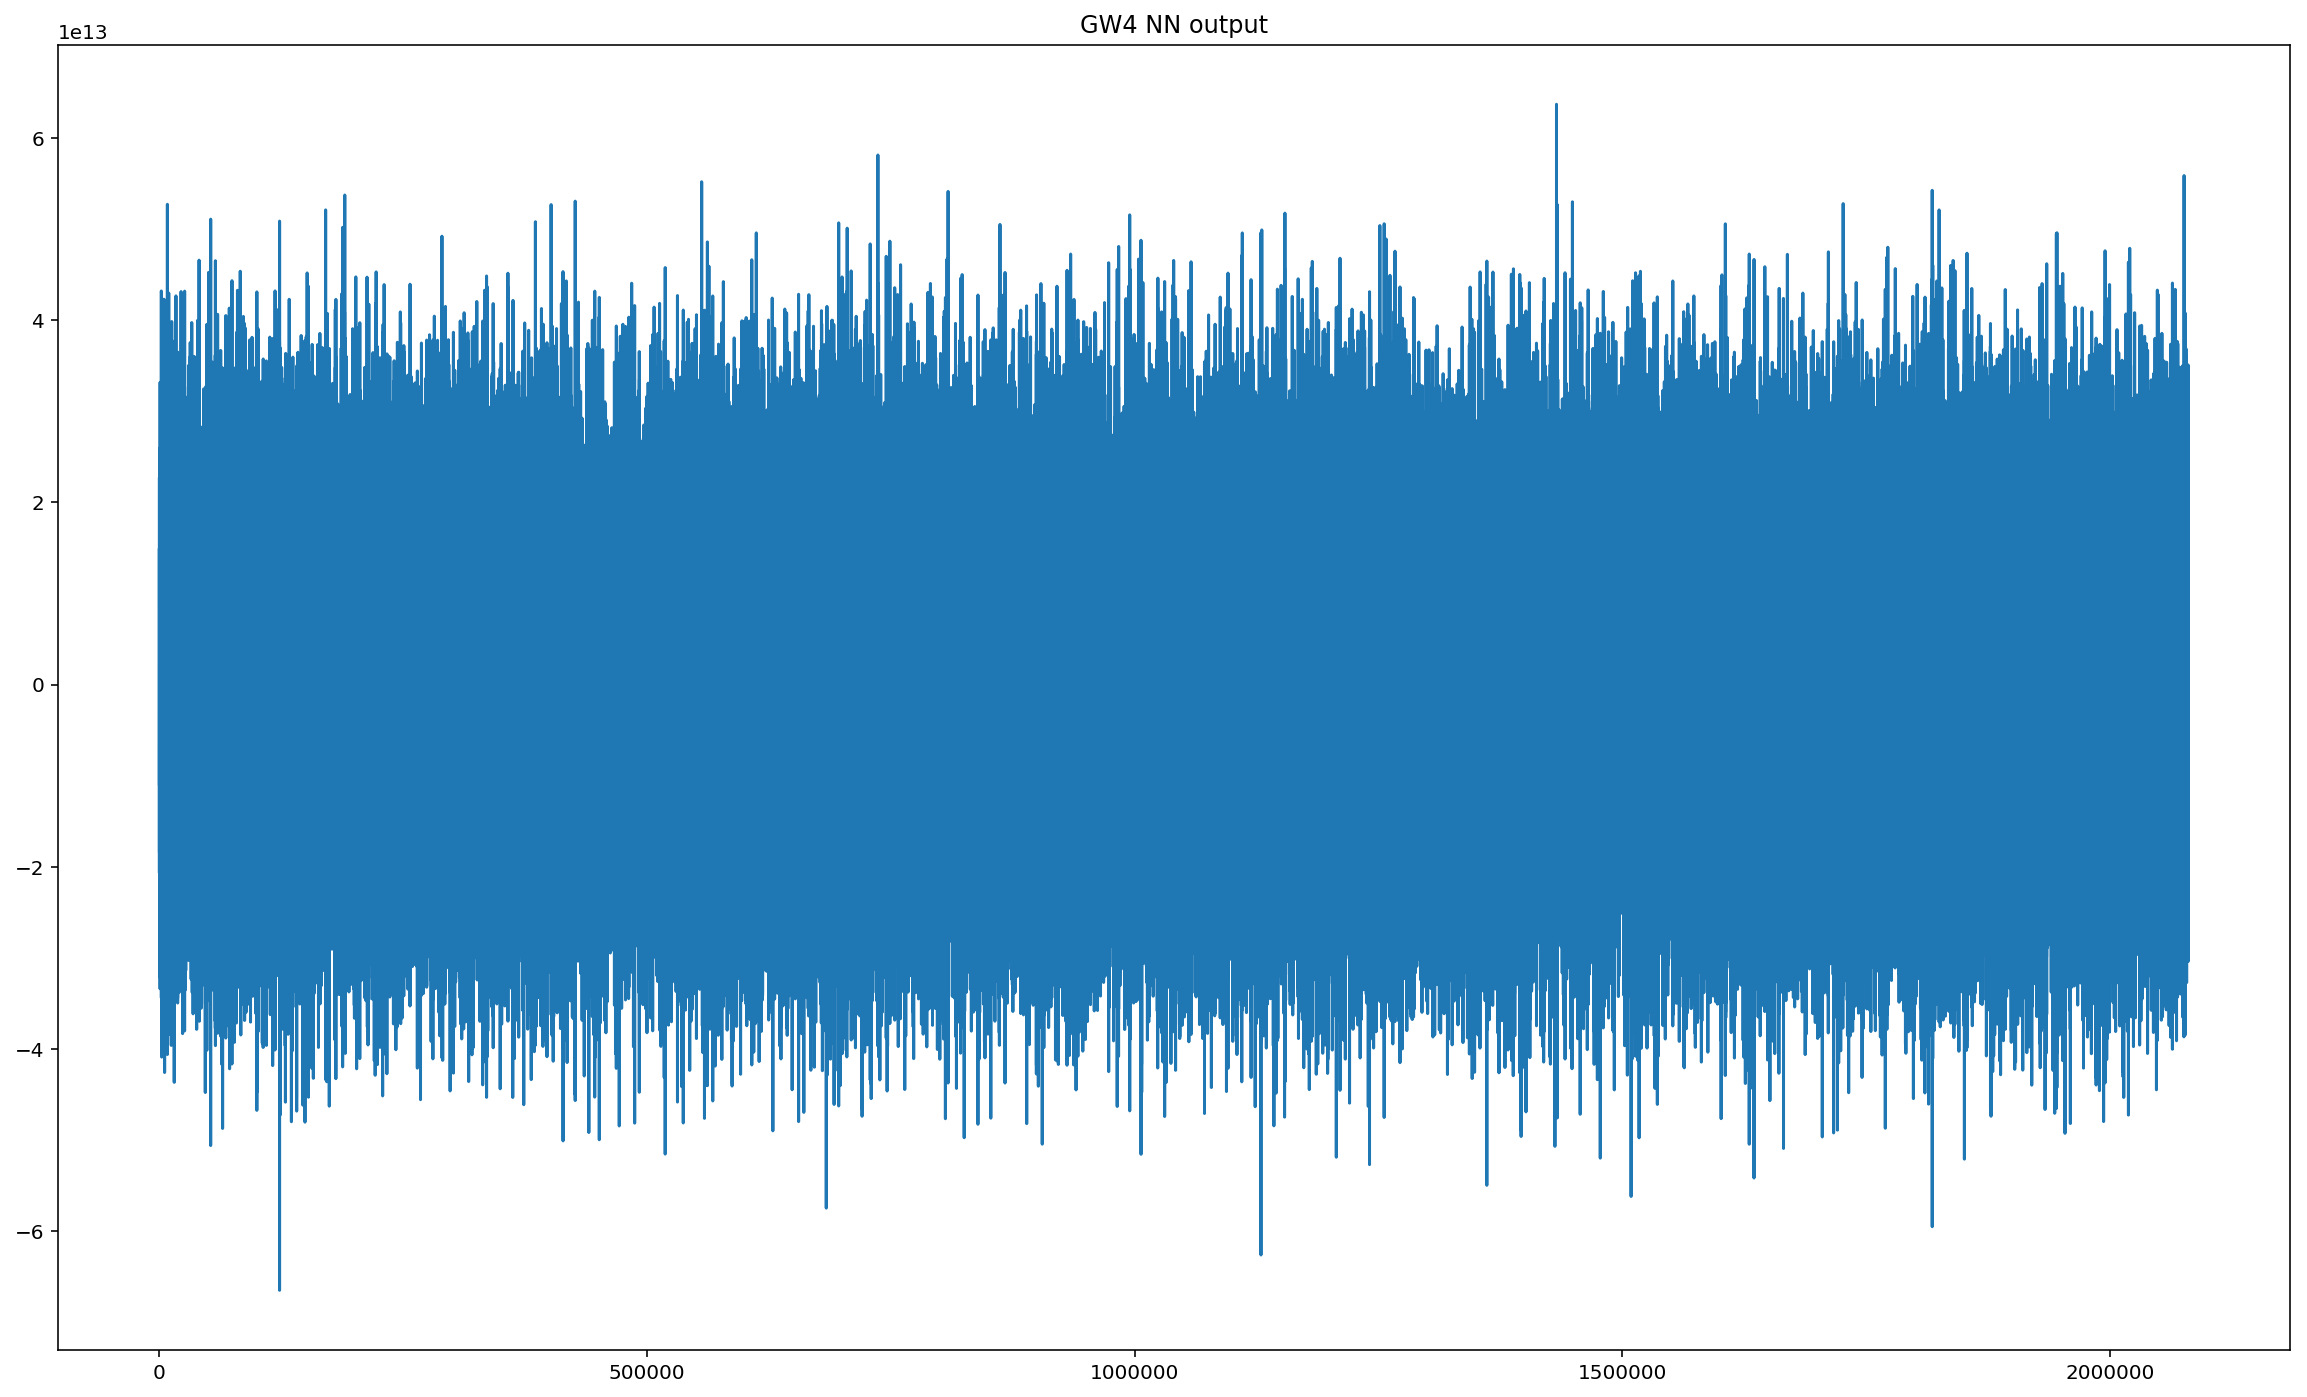

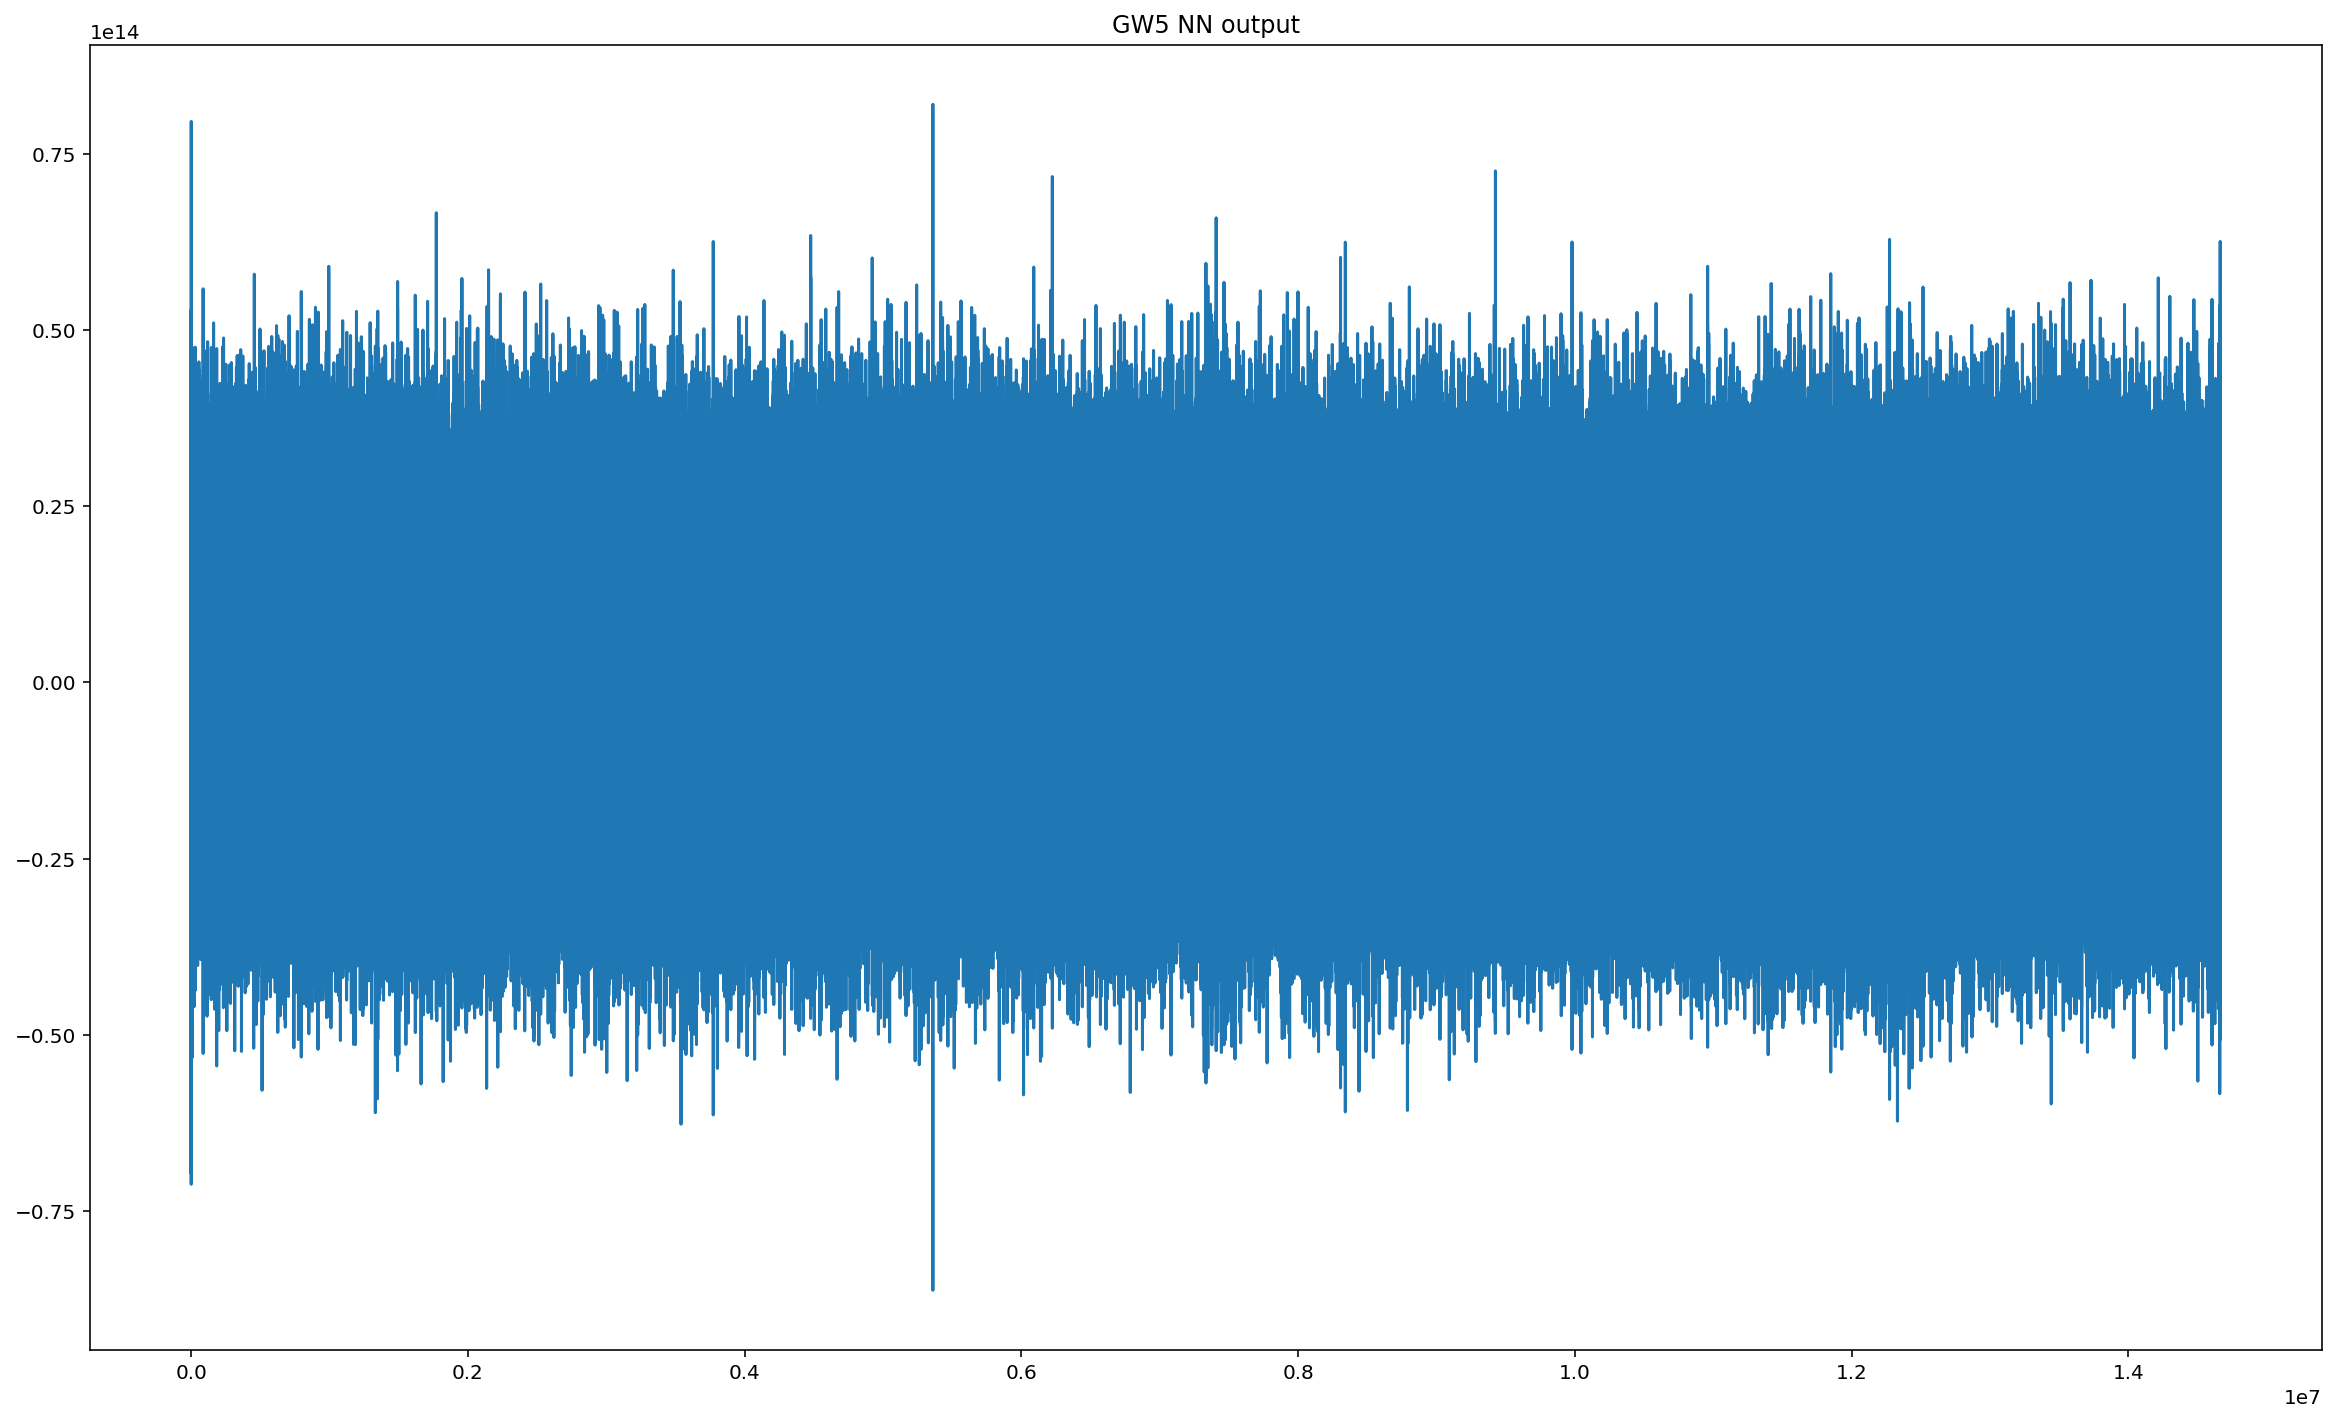

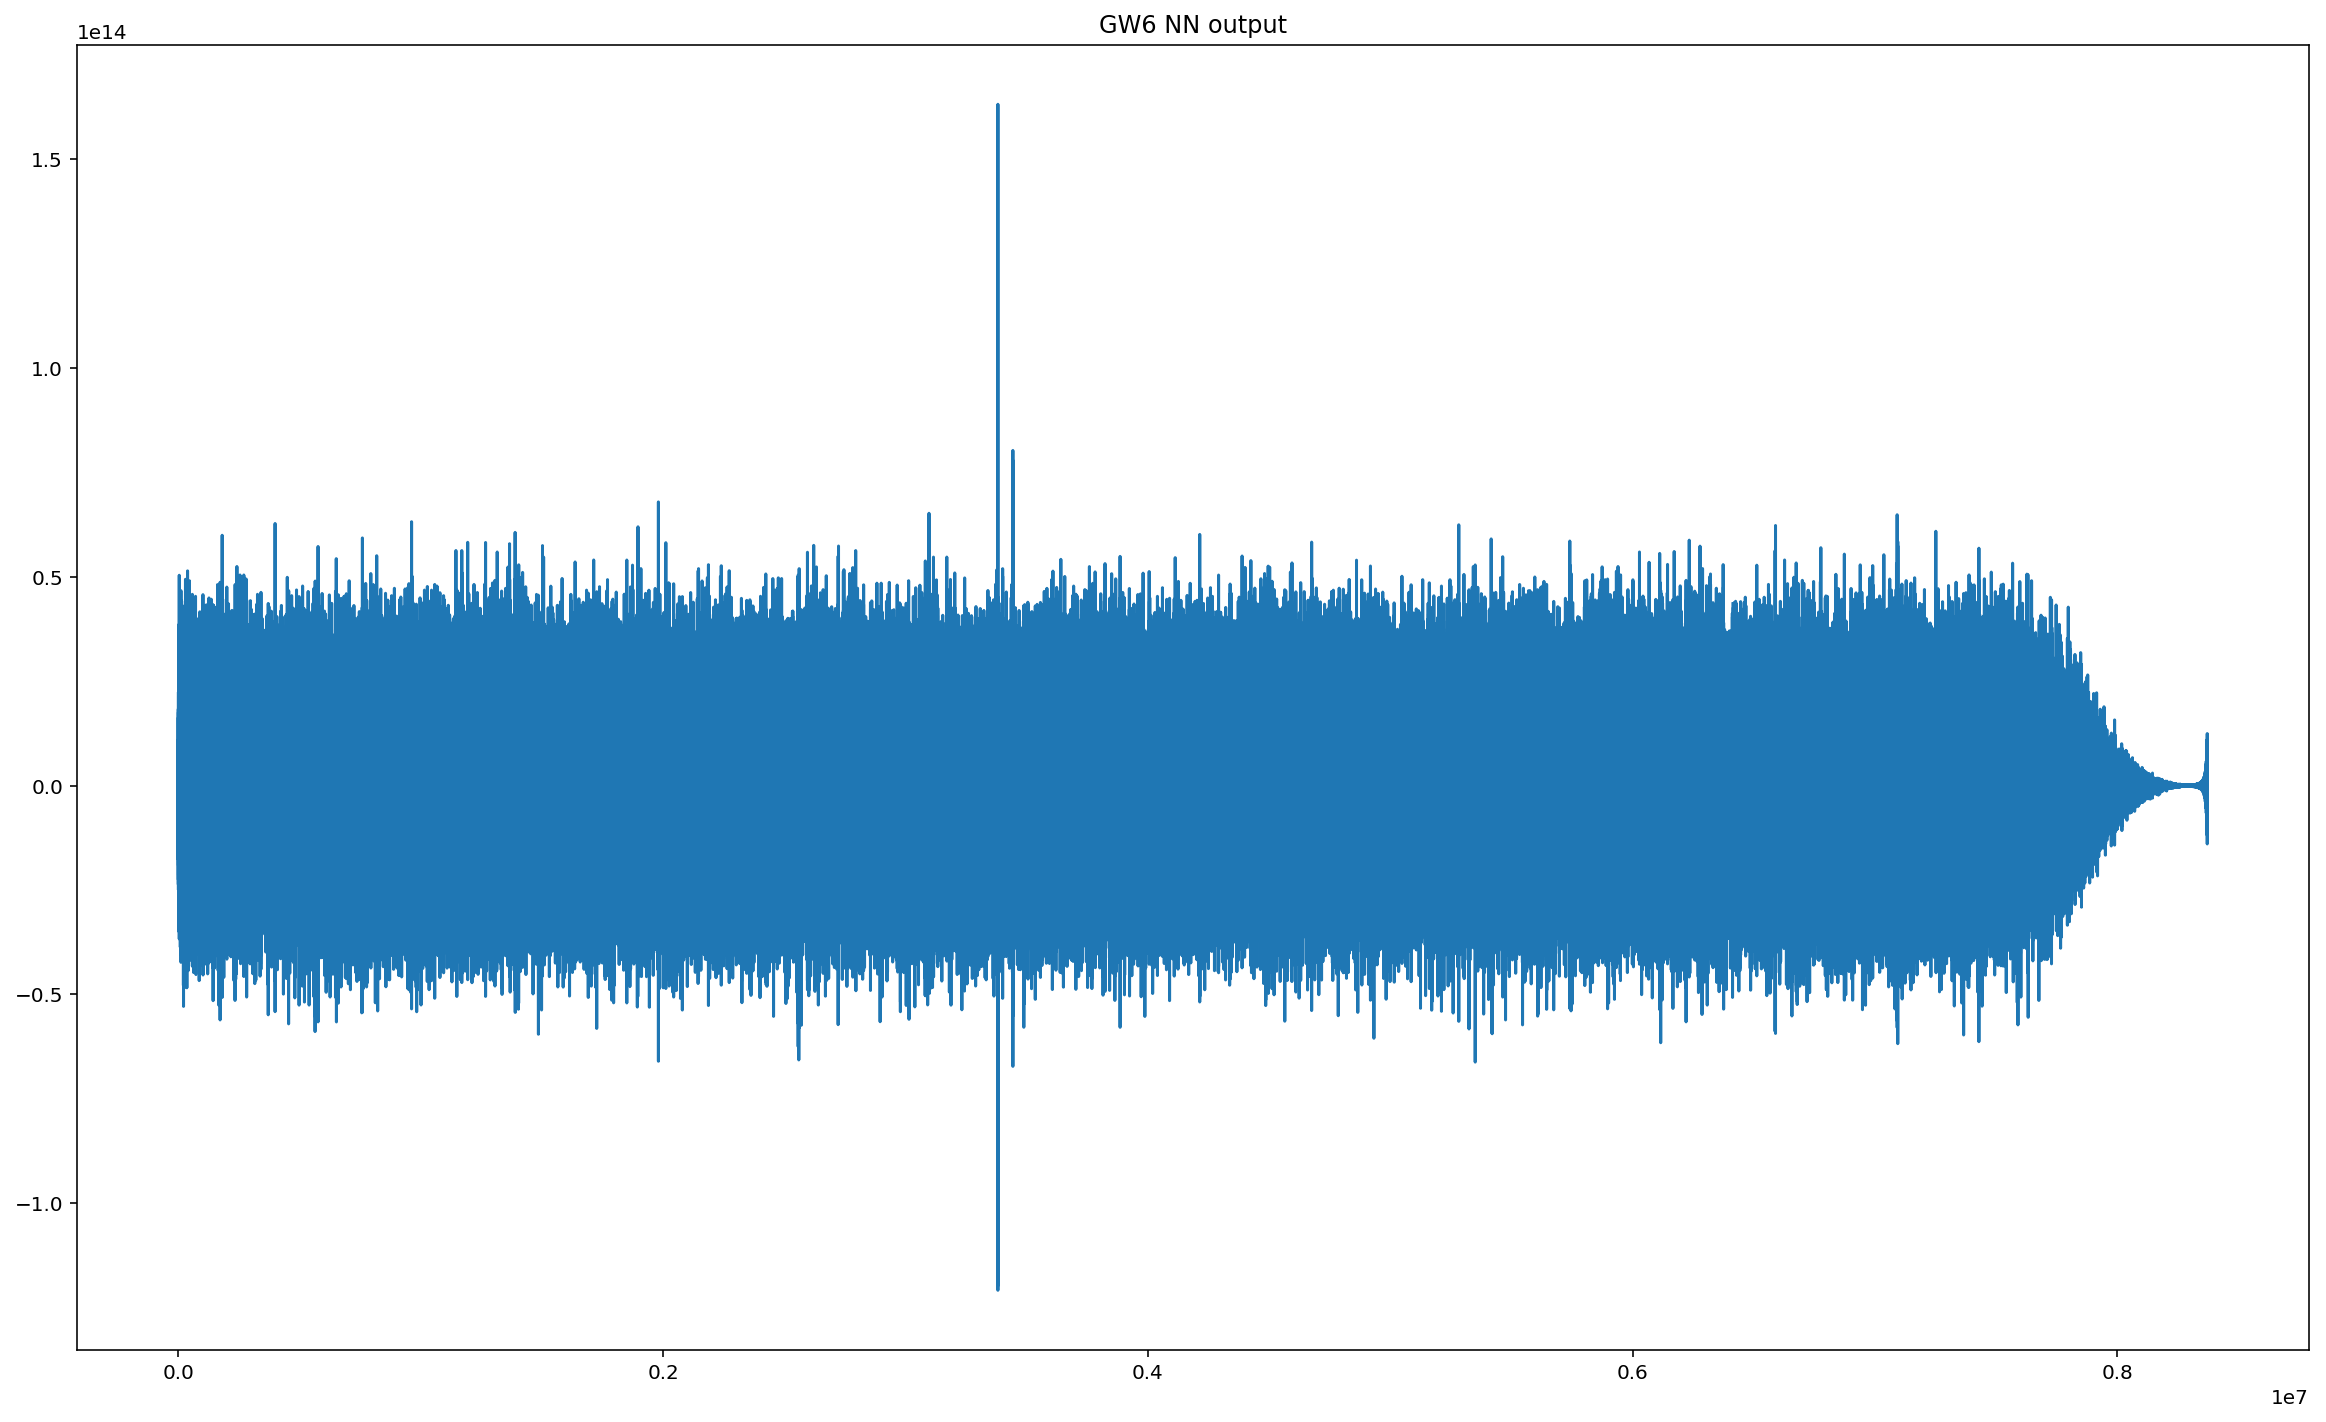

In [24]:
#n_freqs = np.arange(0,2048, 128)
fs = 5 # saw good performace with denominator 5, rather than 4096
n_freqs = np.arange(1,9,2) # every odd integer from 1 to 37


fn_NR = 'data/GW150914_4_NR_waveform.txt'

for GW, d in S2.items():
    print("Loading and cleaning", GW)
    S2Vi, F2Vi, NRVi = LIGO(d['H1'], d['L1'], fn_NR, [d['tevent'],d['shift']])
    
    sig = S2Vi['strain_H1_whitenbp']
    
    print("Neural net", GW)
        
    sigi_first_output = first_layer(sig, windows, n_freqs, fs)
    sigi_second_output = output_layer(sigi_first_output)
    
    print("Plot", GW)
    
    plot_NN(sigi_second_output, GW)